In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [4]:
data_train = pd.read_csv(r'C:\Users\20193727\PycharmProjects\2IOI0-group-16(2)\data\BPI2012Training.csv')
data_test = pd.read_csv(r'C:\Users\20193727\PycharmProjects\2IOI0-group-16(2)\data\BPI2012Test.csv')
data_time_LSTM = pd.read_csv(r'C:\Users\20193727\Downloads\out.csv')

In [5]:
def parseData(dataSet):
    # Parse time zone if there are any
    def convertToUnix(x):
        # If there is a timezone in the timestamp
        if 'T' in x:
            # Remove the T
            without_timezone = x[:10] + ' ' + x[11:-6]

            # Parse milliseconds if contained
            if '.' in x:
                wholesomeTime = dt.datetime.timestamp(
                    dt.datetime.strptime(without_timezone, "%Y-%m-%d %H:%M:%S.%f"))
            else:
                wholesomeTime = dt.datetime.timestamp(
                    dt.datetime.strptime(without_timezone, "%Y-%m-%d %H:%M:%S"))

        else:
            if '.' in x:
                wholesomeTime = dt.datetime.timestamp(
                    dt.datetime.strptime(x, "%d-%m-%Y %H:%M:%S.%f"))
            else:
                wholesomeTime = dt.datetime.timestamp(
                    dt.datetime.strptime(x, "%d-%m-%Y %H:%M:%S"))

        return wholesomeTime

    # Convert absolute event and reg timestamp into unix time
    dataSet['unix_abs_event_time'] = dataSet['event time:timestamp'].apply(
        lambda x: convertToUnix(x))
    dataSet['unix_reg_time'] = dataSet['case REG_DATE'].apply(
        lambda x: convertToUnix(x))

    # Time it takes for an event to occur from registeration
    dataSet['unix_rel_event_time'] = dataSet['unix_abs_event_time'] - \
        dataSet['unix_reg_time']

    # Group data set by case ID
    dataSet_grouped_by_case = dataSet.groupby(by=['case concept:name'])

    # Return data frame consisting out of the last event per case with column that indicates the number of events the case underwent appended
    dataSet_last_event_per_case = dataSet_grouped_by_case.nth([-1])
    dataSet_last_event_per_case['num_events'] = dataSet_grouped_by_case.count(
    ).iloc[:, 0]

    return (dataSet, dataSet_last_event_per_case)

In [6]:
train_parsed, last_event_train = parseData(data_train)
test_parsed, last_event_test = parseData(data_test)

In [7]:
train_parsed.head()

,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,event concept:name,event lifecycle:transition,event time:timestamp,unix_abs_event_time,unix_reg_time,unix_rel_event_time
0,0,173688,2011-10-01T00:38:44.546+02:00,20000,A_SUBMITTED,COMPLETE,01-10-2011 00:38:44.546,1.317422e+09,1.317422e+09,0.000
1,1,173688,2011-10-01T00:38:44.546+02:00,20000,A_PARTLYSUBMITTED,COMPLETE,01-10-2011 00:38:44.880,1.317422e+09,1.317422e+09,0.334
2,2,173688,2011-10-01T00:38:44.546+02:00,20000,A_PREACCEPTED,COMPLETE,01-10-2011 00:39:37.906,1.317422e+09,1.317422e+09,53.360
3,3,173688,2011-10-01T00:38:44.546+02:00,20000,W_Completeren aanvraag,SCHEDULE,01-10-2011 00:39:38.875,1.317422e+09,1.317422e+09,54.329
4,4294967296,173691,2011-10-01T08:08:58.256+02:00,5000,A_SUBMITTED,COMPLETE,01-10-2011 08:08:58.256,1.317449e+09,1.317449e+09,0.000


In [47]:
def barchart_event_time(data):
    averages = []
    events = []
    
    for event in data['event concept:name'].unique()[1:]:
        relevant_events = data[data['event concept:name'] == event]
        average = sum(relevant_events['unix_rel_event_time'])/len(relevant_events)
        #event_average = average
        averages.append(average)
        events.append(event) 
    
    #raw_data = {'event':events,'average_time': averages}
    #df = pd.DataFrame(raw_data)
    
    sorted_events = [events for _,events in sorted(zip(averages,events))]
    sorted_averages = sorted(averages)
    
    y_pos = range(len(events))
    plt.bar(y_pos, sorted_averages)
    plt.xticks(y_pos, sorted_events, rotation = 45, horizontalalignment='right', fontweight='light', fontsize='x-small')
    plt.title('Average time until an event happens after the start of the case')
    plt.show()
    

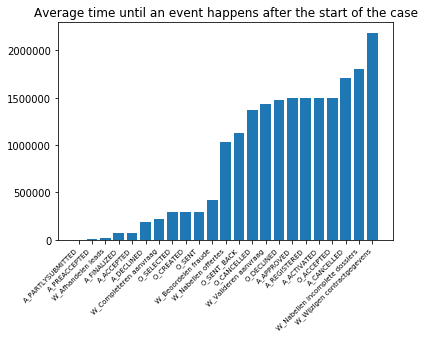

In [48]:
barchart_event_time(train_parsed)

In [21]:
import math

In [22]:
data_time_LSTM.head()

,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,event concept:name,event lifecycle:transition,event time:timestamp,unix_abs_event_time,unix_reg_time,unix_rel_event_time,actual_time_to_next_event,naive_predicted_time_to_next_event,actual_next_event,naive_predicted_next_event,timePrediction
0,0,173688,2011-10-01T00:38:44.546+02:00,20000,A_SUBMITTED,COMPLETE,01-10-2011 00:38:44.546,1.317422e+09,1.317422e+09,0.000,0.334,0.574344,A_PARTLYSUBMITTED,A_PARTLYSUBMITTED,-8945.97300
1,1,173688,2011-10-01T00:38:44.546+02:00,20000,A_PARTLYSUBMITTED,COMPLETE,01-10-2011 00:38:44.880,1.317422e+09,1.317422e+09,0.334,53.026,34.626307,A_PREACCEPTED,A_PREACCEPTED,-7013.89650
2,2,173688,2011-10-01T00:38:44.546+02:00,20000,A_PREACCEPTED,COMPLETE,01-10-2011 00:39:37.906,1.317422e+09,1.317422e+09,53.360,0.969,0.593875,W_Completeren aanvraag,W_Completeren aanvraag,-6434.75730
3,3,173688,2011-10-01T00:38:44.546+02:00,20000,W_Completeren aanvraag,SCHEDULE,01-10-2011 00:39:38.875,1.317422e+09,1.317422e+09,54.329,39427.562,49675.208262,W_Completeren aanvraag,W_Completeren aanvraag,13340.17300
4,4,173688,2011-10-01T00:38:44.546+02:00,20000,W_Completeren aanvraag,START,01-10-2011 11:36:46.437,1.317462e+09,1.317422e+09,39481.891,356.871,49675.208262,A_ACCEPTED,W_Completeren aanvraag,-418.58405


In [49]:
def barchart_MSE_timeLSTM(df_time):
    event_list = []
    MSE_list = []
    RMSE_list = []
    
    for event in df_time['event concept:name'].unique():
        rel_pred = df_time[df_time['event concept:name'] == event]
        total_SE = 0
        
        for idx in rel_pred.index:
            SE = ((rel_pred['actual_time_to_next_event'][idx] - rel_pred['timePrediction'][idx])**2)
            total_SE += SE
        
        MSE = total_SE / len(rel_pred)
        RMSE = math.sqrt(MSE)
        
        RMSE_list.append(RMSE)
        event_list.append(event)
        MSE_list.append(MSE)
        
    y_pos = range(len(RMSE_list))
    plt.bar(y_pos, RMSE_list)
    plt.xticks(y_pos, event_list, rotation = 45, horizontalalignment='right', fontweight='light', fontsize='x-small') #original is just rotation=90 after that nothing
    plt.title('RMSE for LSTM time prediction per event')
    plt.show()

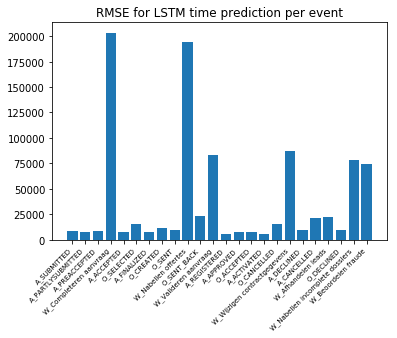

In [50]:
barchart_MSE_timeLSTM(data_time_LSTM)

In [45]:
def barchart_MSE_time_naive(df_time):
    event_list = []
    MSE_list = []
    RMSE_list = []
    
    for event in df_time['event concept:name'].unique():
        rel_pred = df_time[df_time['event concept:name'] == event]
        total_SE = 0
        
        for idx in rel_pred.index:
            SE = ((rel_pred['actual_time_to_next_event'][idx] - rel_pred['naive_predicted_time_to_next_event'][idx])**2)
            total_SE += SE
        
        MSE = total_SE / len(rel_pred)
        RMSE = math.sqrt(MSE)
        
        RMSE_list.append(RMSE)
        event_list.append(event)
        MSE_list.append(MSE)
        
    y_pos = range(len(RMSE_list))
    plt.bar(y_pos, RMSE_list)
    plt.xticks(y_pos, event_list, rotation = 45, horizontalalignment='right', fontweight='light', fontsize='x-small')
    plt.title('RMSE for naive time prediction per event')
    plt.show()

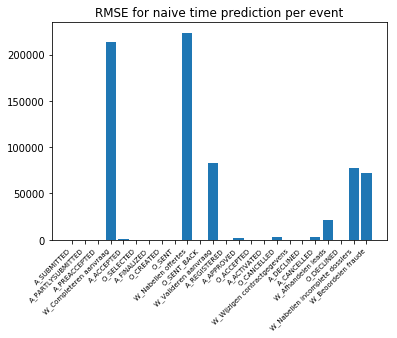

In [46]:
barchart_MSE_time_naive(data_time_LSTM)